In [1]:
get_ipython().magic('matplotlib inline')
get_ipython().magic('config InlineBackend.figure_format = "retina"')

import matplotlib.pyplot as pl

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
from configobj import ConfigObj
from astropy import constants as c
from astropy import units as u
import pprint

import limbdark

pp = pprint.PrettyPrinter(indent=2)

def map_int(x):
    return list(map(int, x))

def map_float(x):
    return list(map(float, x))

sys.path.append('..')
from transitfit import TransitFit
from transitfit.util import mad_outliers, get_init_params, u_to_q

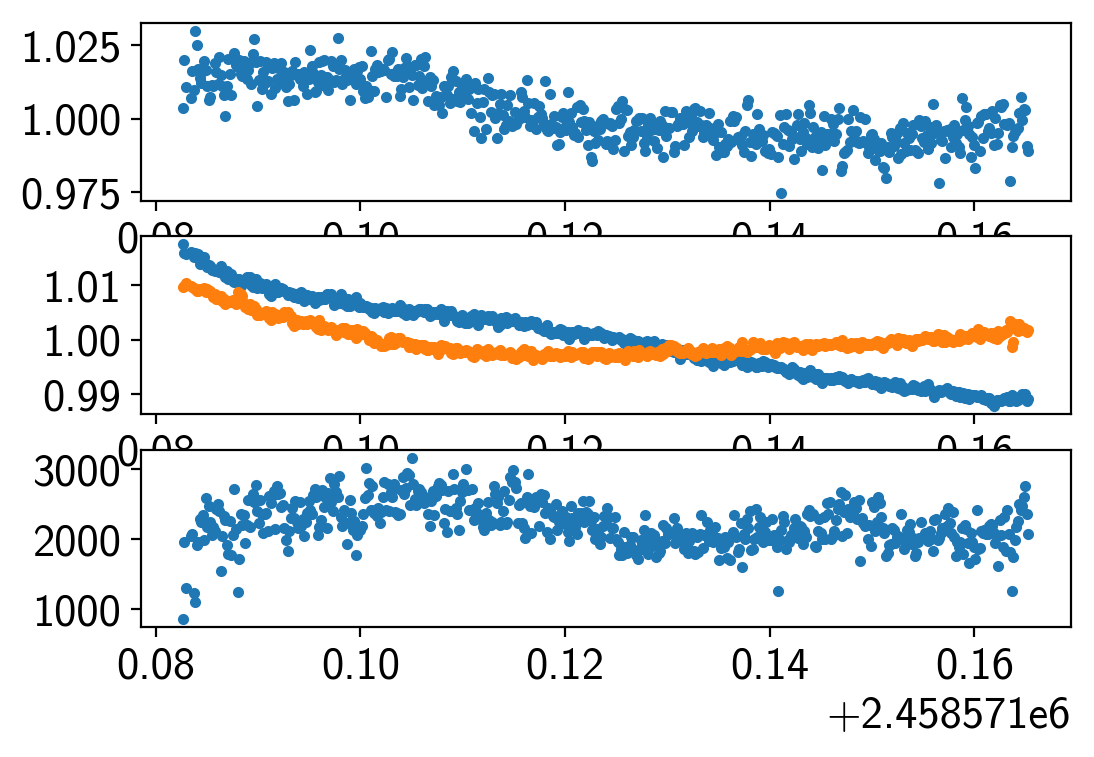

In [3]:
fp = '../data/20190328-TNT-TOI515_01-g.txt'
df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split())

time, flux, cenx, ceny, peak = df.values.T

time += 2400000.5
flux /= np.median(flux)

fig, axs = pl.subplots(3, 1)
axs[0].plot(time, flux, '.')
axs[1].plot(time, cenx/cenx.mean(), '.')
axs[1].plot(time, ceny/ceny.mean(), '.')
axs[2].plot(time, peak, '.')

0


<Container object of 3 artists>

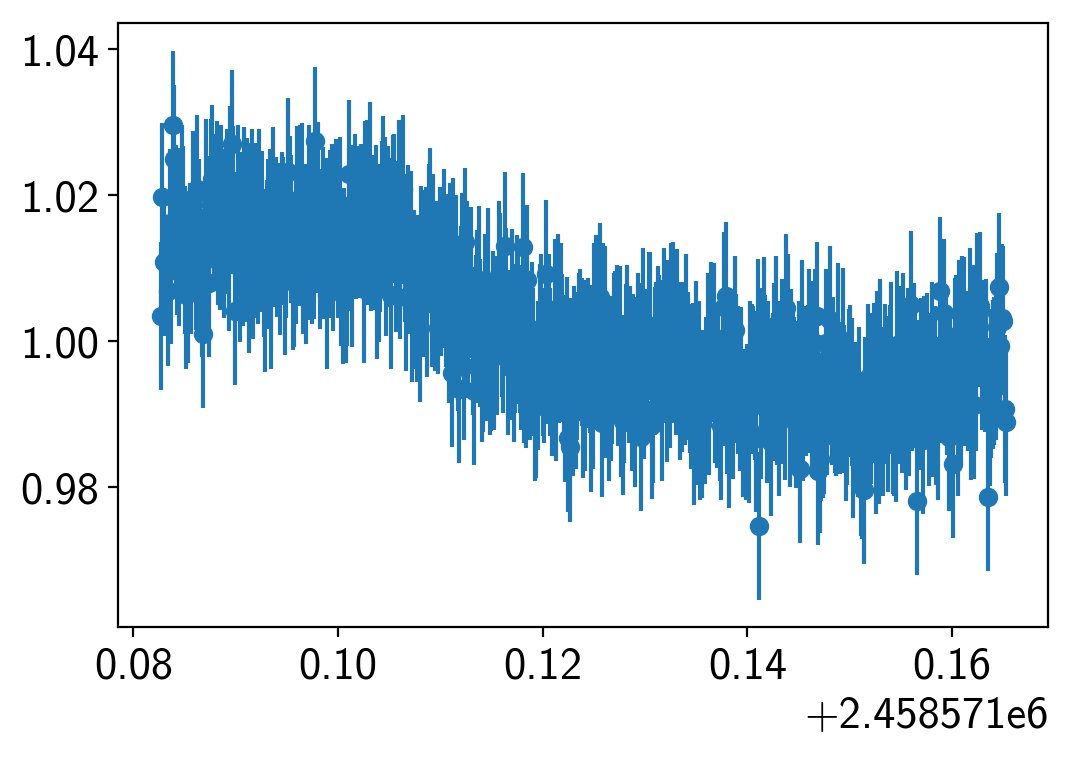

In [16]:
# aux = np.c_[np.ones_like(time), time-time.min(), (time-time.min())**2, cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]
aux = np.c_[np.ones_like(time), time-time.min(), cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]

idx = mad_outliers(flux)
print(idx.sum())

time, flux, aux = time[~idx], flux[~idx], aux[~idx]
unc = flux.std()

pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [17]:
# bin the data
##############

# fp = 'TOI-136_irsf_181007_j.csv'
# df = pd.read_csv(fp)

# idx = mad_outliers(df['flux'].values)
# print('omitting {} outliers'.format(idx.sum()))
# df = df[~idx]

# binsize_min = 5
# binsize = binsize_min / (60 * 24)
# print(np.diff(df['BJD_TDB']).mean()*86400)
# bins = np.arange(df['BJD_TDB'].min(), df['BJD_TDB'].max(), binsize)
# groups = df.groupby(np.digitize(df['BJD_TDB'], bins))
# df_binned = groups.mean()
# df = df_binned.copy()

# aux = df['airmass sky dx dy fwhm peak'.split()].values
# time, flux, unc = df['BJD_TDB flux err'.split()].values.T
# pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [18]:
band = 'g*'

planets = { 'TOI515.01': 
           { 
               'per': 3.115247,
               't0': 2458493.283,
               't14': 0.096,
               'rprs': 0.16
           }
          }

star = {
    'teff': [4973, 172],
    'logg': [4.5, 0.5],
    'feh': [0.0, 0.5],
    'rad': [0.7, 0.1],
}

teff, logg, feh = [star.get(k) for k in 'teff logg feh'.split()]

ldp = limbdark.claret(band, teff[0], teff[1], logg[0], logg[1], feh[0], feh[1])
u1, u2 = ldp[0], ldp[2]
q1, q2 = u_to_q(u1, u2)

# logg = map_float(star['logg'])
# rad = map_float(star['rad'])
# n = 10000
# rad_s = rad[0] + np.random.randn(n) * rad[1]
# logg_s = logg[0] + np.random.randn(n) * logg[1]
# rho_s = rho(logg_s, rad_s)
# rhop = rho_s.mean(), rho_s.std()

# priors = dict(ld=ldp, rho=rhop)

pl_name = list(planets.keys())[0]
planet = planets[pl_name]
per, t0, t14, rprs = [planet.get(key) for key in 'per t0 t14 rprs'.split()]

while t0 < time.min():
    t0 += per
    
t0p = t0, 0.002097
perp = per, 0.000192
t14p = t14, 0.02
priors = dict(ld=ldp, t0=t0p, per=perp, t14=t14p)
# priors = None

init_params = get_init_params(per, t0, t14, rprs, b=0.5, q1=q1, q2=q2)
init_params['priors'] = priors
init_params['ls'] = np.log(flux.std())
pp.pprint(init_params)

{ 'b': 0.5,
  'k': 0.16,
  'ls': -4.591470692323312,
  'p': 3.115247,
  'priors': { 'ld': (0.8026, 0.08340290124468333, 0.0283, 0.07168435338565592),
              'per': (3.115247, 0.000192),
              't0': (2458571.164175, 0.002097),
              't14': (0.096, 0.02)},
  'q1': 0.6903948099999999,
  'q2': 0.4829702731977374,
  'r': 1.41,
  't0': 2458571.164175,
  't14': 0.096}


In [19]:
# fit = TransitFit(init_params, pl_name, time, flux, unc=unc, aux=aux)
fit = TransitFit(init_params, pl_name, time, flux, aux=aux)

In [20]:
fit.fit_map()

Initial L-M least squares fit successful
[[Variables]]
    t0:   2.4586e+06 +/- 0        (0.00%) (init= 2458571)
    p:    3.115247 (fixed)
    k:    0.16 (fixed)
    r:    1.41 (fixed)
    b:    0.05827956 +/- 0        (0.00%) (init= 0.5)
    q1:   0.6903948 (fixed)
    q2:   0.4829703 (fixed)
    ls:  -4.591471 (fixed)
    c0:  -0.13305557 +/- 0        (0.00%) (init= 0)
    c1:   0.26143239 +/- 0        (0.00%) (init= 0)
    c2:   0.09807040 +/- 0        (0.00%) (init= 0)
    c3:   0.04701312 +/- 0        (0.00%) (init= 0)
    c4:  -0.00076147 +/- 0        (0.00%) (init= 0)
None
Transit depth: 25600 [ppm]
Transit duration: 3.08 [h]
Log-probability: 1992.3231000106832
True
[[Variables]]
    t0:   2458571 (fixed)
    p:    3.115247 (fixed)
    k:    0.16 (fixed)
    r:    1.41 (fixed)
    b:    9.4073e-07 (init= 0.05827957)
    q1:   0.6903948 (fixed)
    q2:   0.4829703 (fixed)
    ls:  -5.27467247 (init=-4.591471)
    c0:  -0.12333859 (init=-0.1330556)
    c1:   0.25219883 (init= 0.2

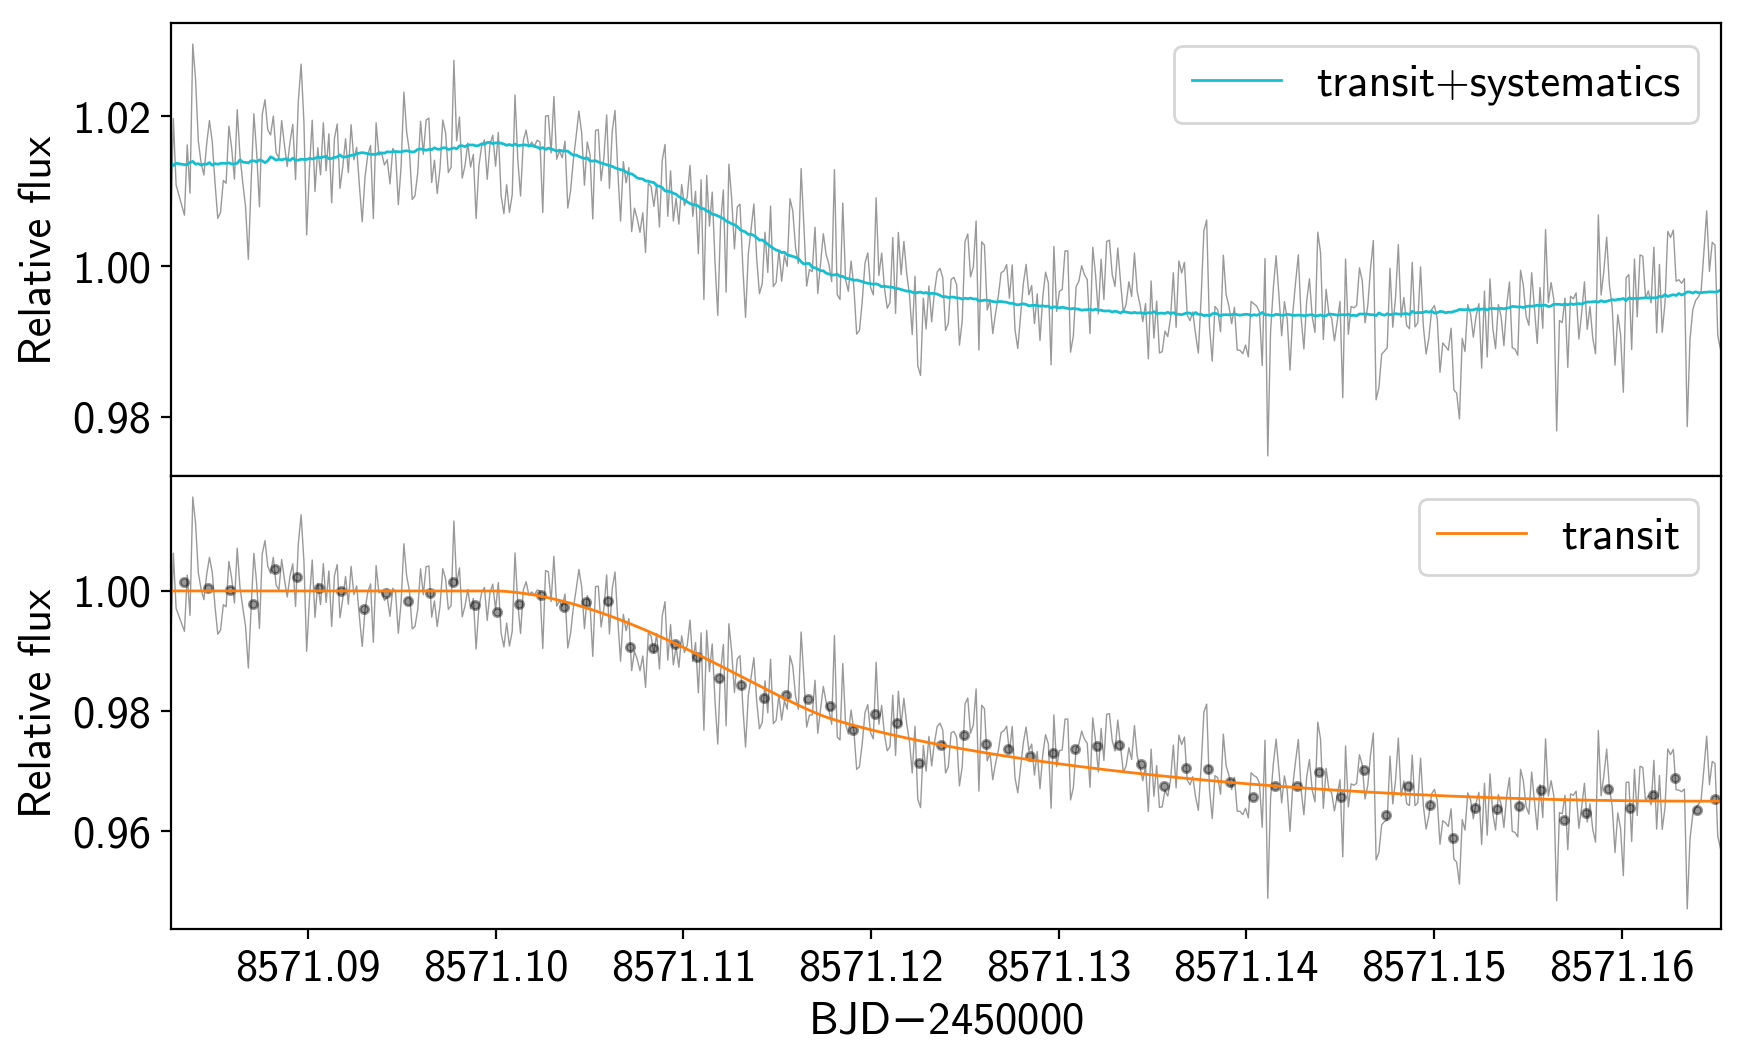

In [21]:
fit.plot_map()

In [22]:
# fit.fit_mcmc(two_stage=True)
fit.fit_mcmc(two_stage=True, steps=2000, nproc=4)

Running stage 1 MCMC (250 steps)...


/Users/jhl/miniconda3/envs/py3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/jhl/miniconda3/envs/py3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Running production MCMC for 2000 steps...


../transitfit/util.py:56: RuntimeWarning: invalid value encountered in arccos
  return np.rad2deg(np.arccos(b / a))


[[Variables]]
    t0:   2.4586e+06 +/- 0.002046 (0.00%) (init= 2458571)
    p:    3.11524274 +/- 0.000199 (0.01%) (init= 3.115247)
    k:    0.13580117 +/- 0.006671 (4.91%) (init= 0.16)
    r:    1.40645512 +/- 0.181729 (12.92%) (init= 1.41)
    b:    0.13951663 +/- 0.144546 (103.61%) (init= 9.407294e-07)
    q1:   0.70933834 +/- 0.142657 (20.11%) (init= 0.6903948)
    q2:   0.49341602 +/- 0.037585 (7.62%) (init= 0.4829703)
    ls:  -5.28645784 +/- 0.028598 (0.54%) (init=-5.274672)
    c0:  -0.10400713 +/- 0.234531 (225.50%) (init=-0.1233386)
    c1:   0.03332190 +/- 0.110031 (330.21%) (init= 0.2521988)
    c2:  -0.19671690 +/- 0.323366 (164.38%) (init= 0.06529528)
    c3:   0.29931821 +/- 0.170258 (56.88%) (init= 0.07045654)
    c4:   0.00255479 +/- 0.001971 (77.15%) (init=-0.0008692155)
None
FIT_MCMC elapsed time: 180 sec


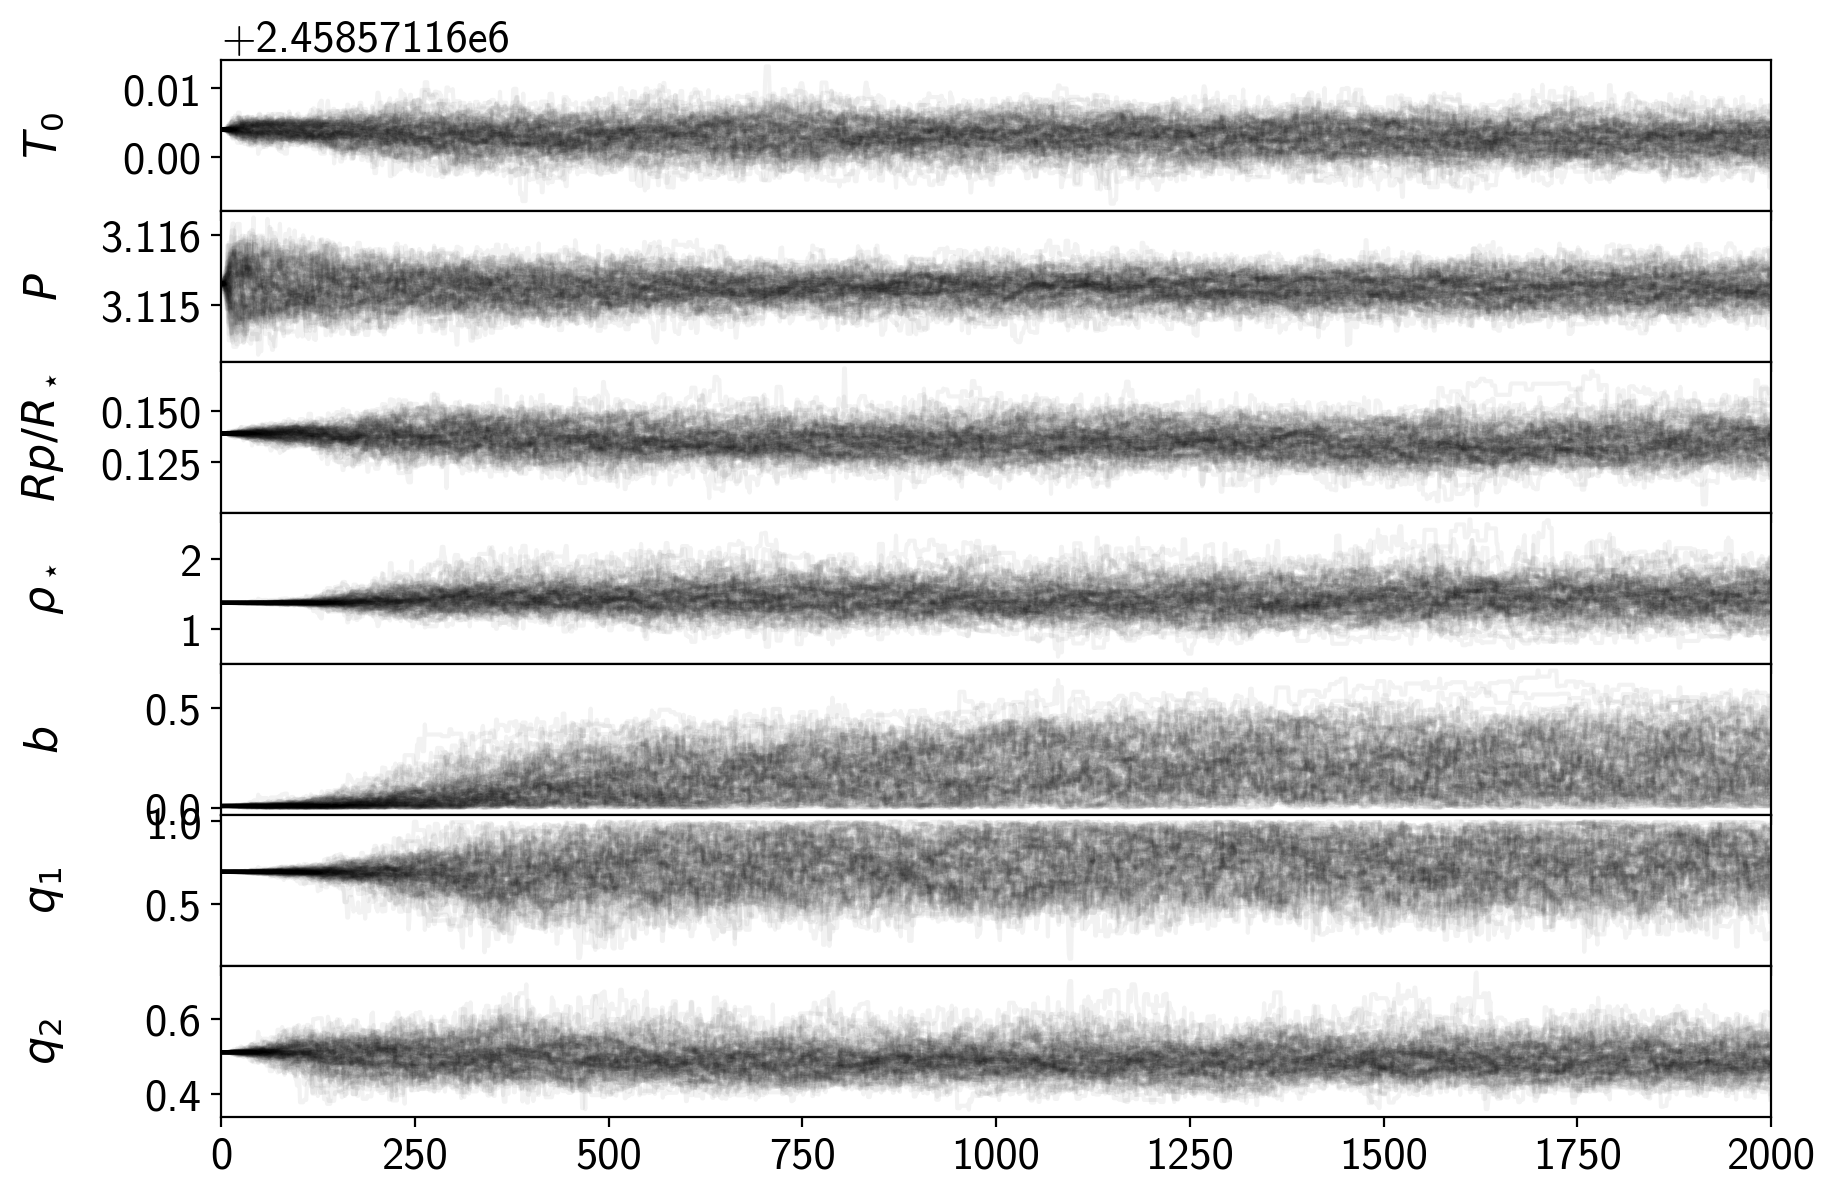

In [23]:
fit.plot_trace()

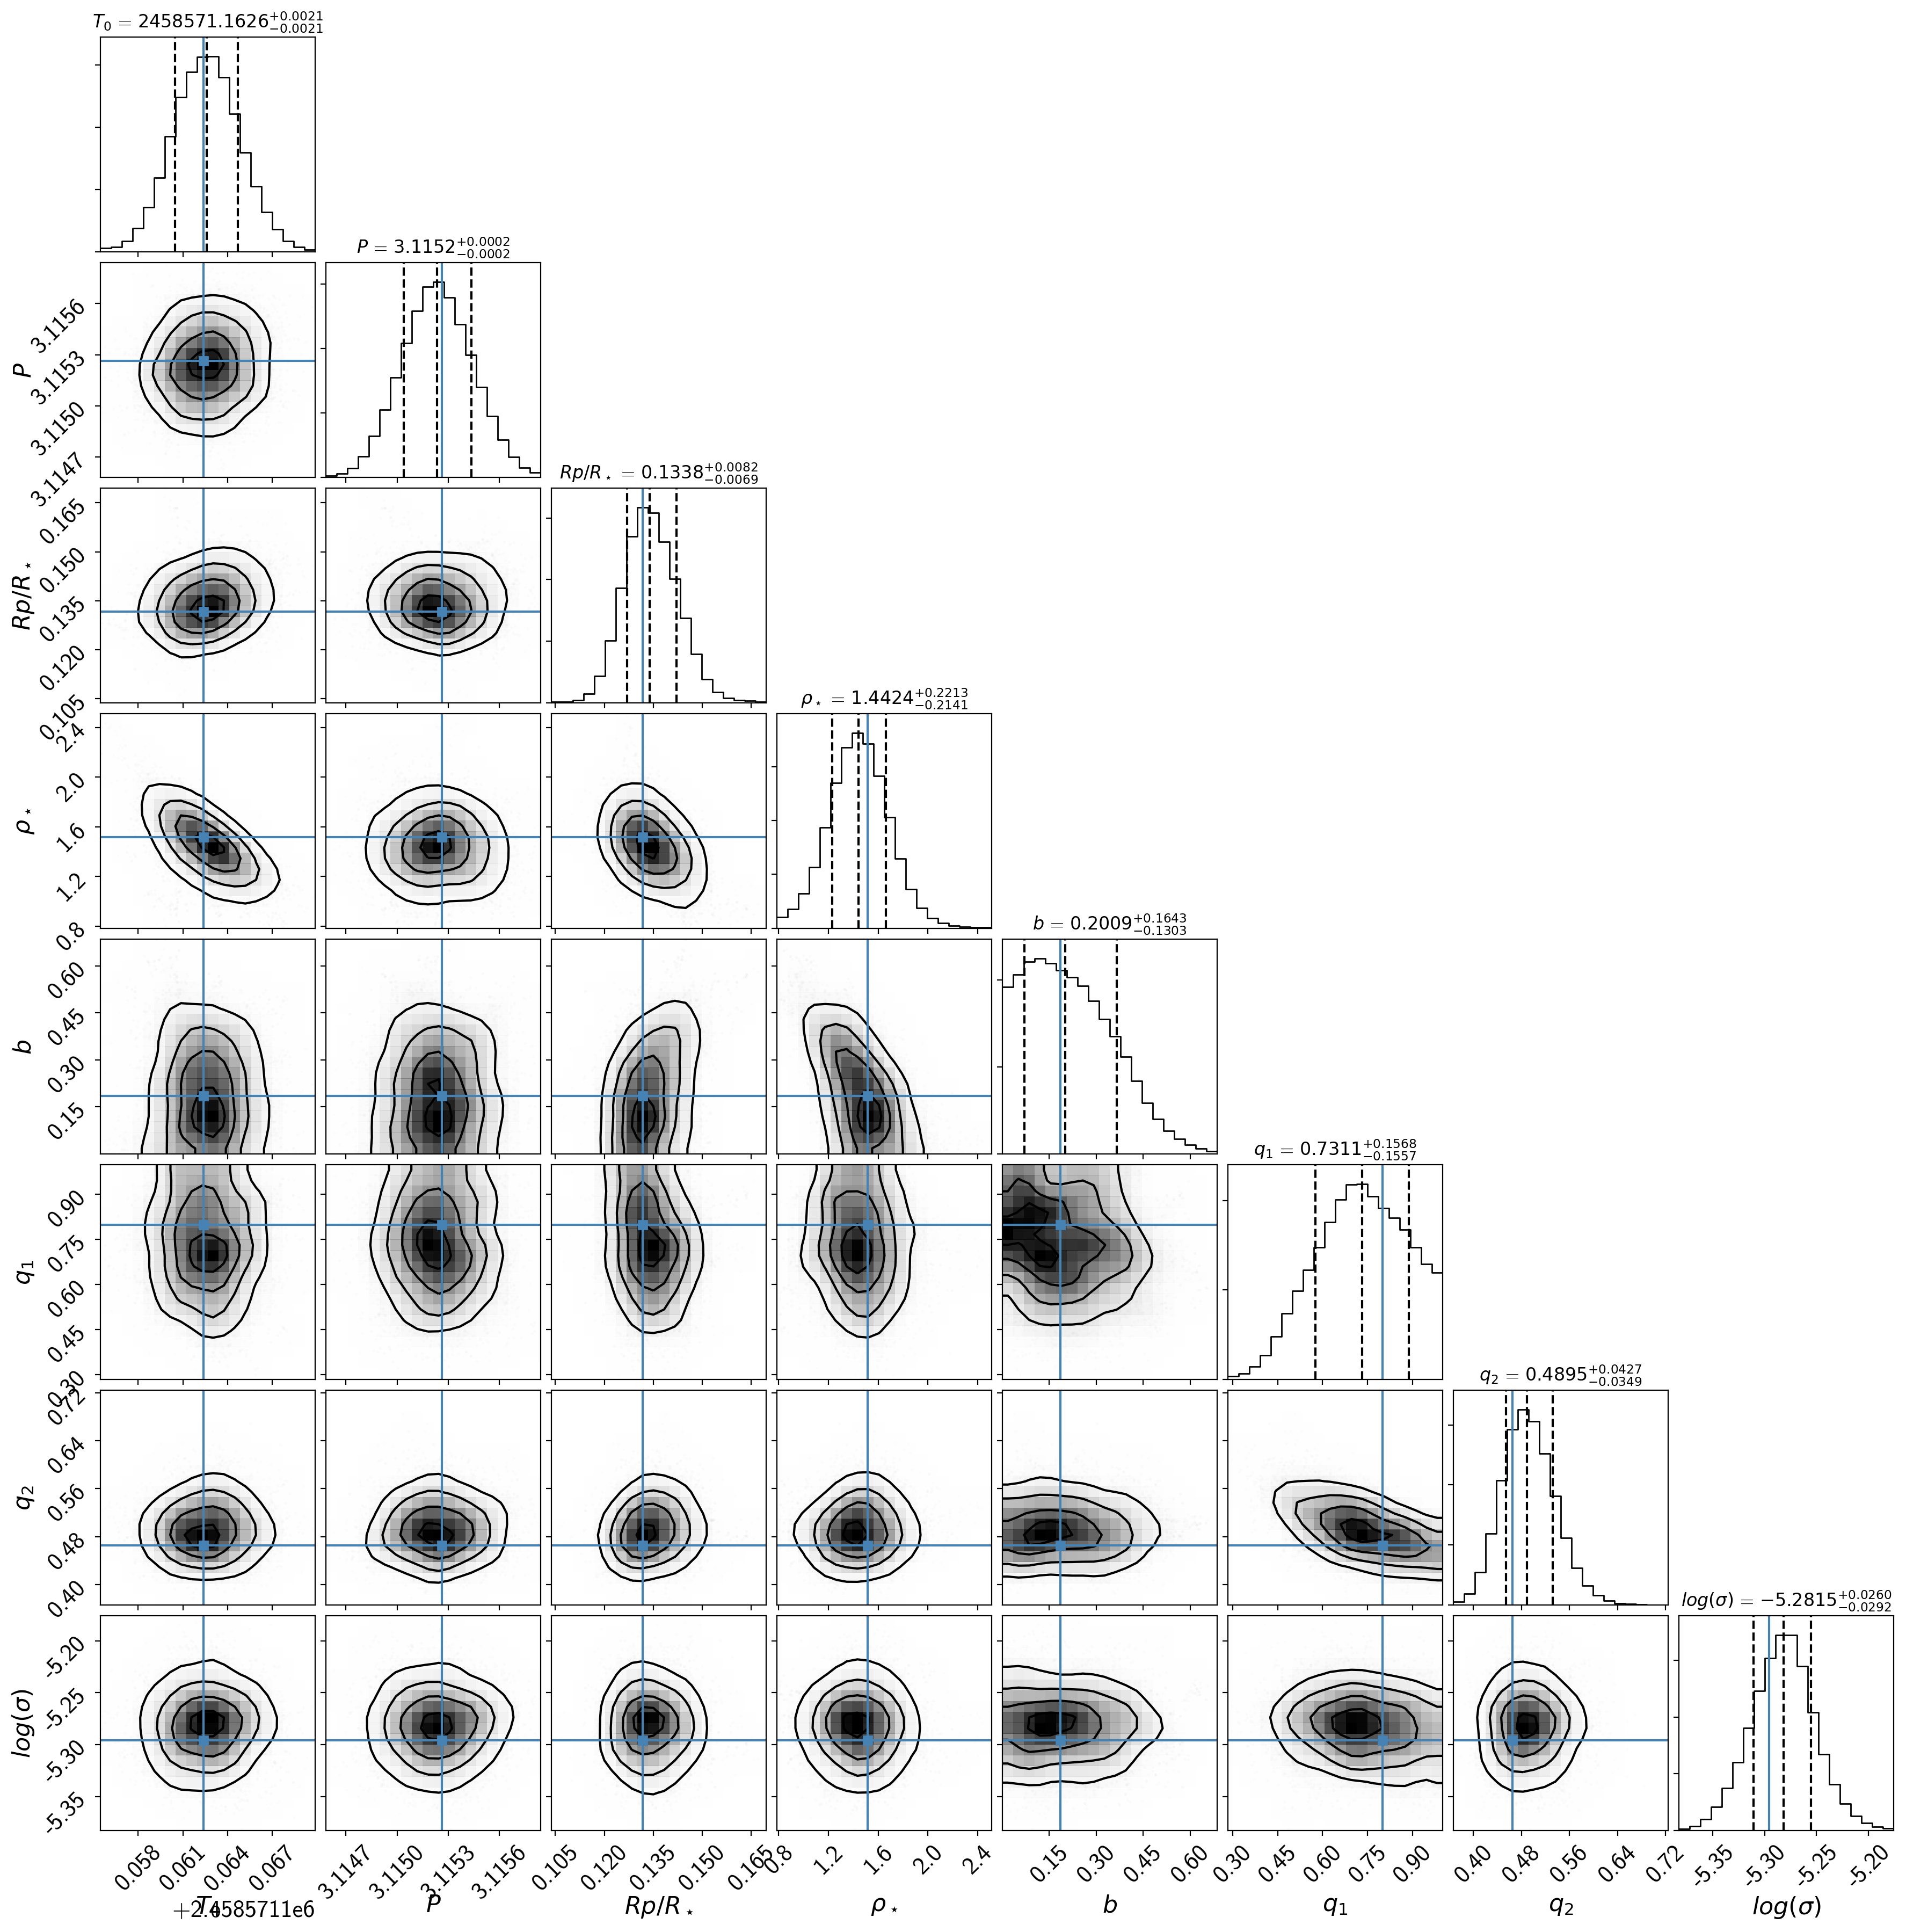

In [24]:
fit.burn_thin(burn=1500, thin=10)
fit.plot_corner()

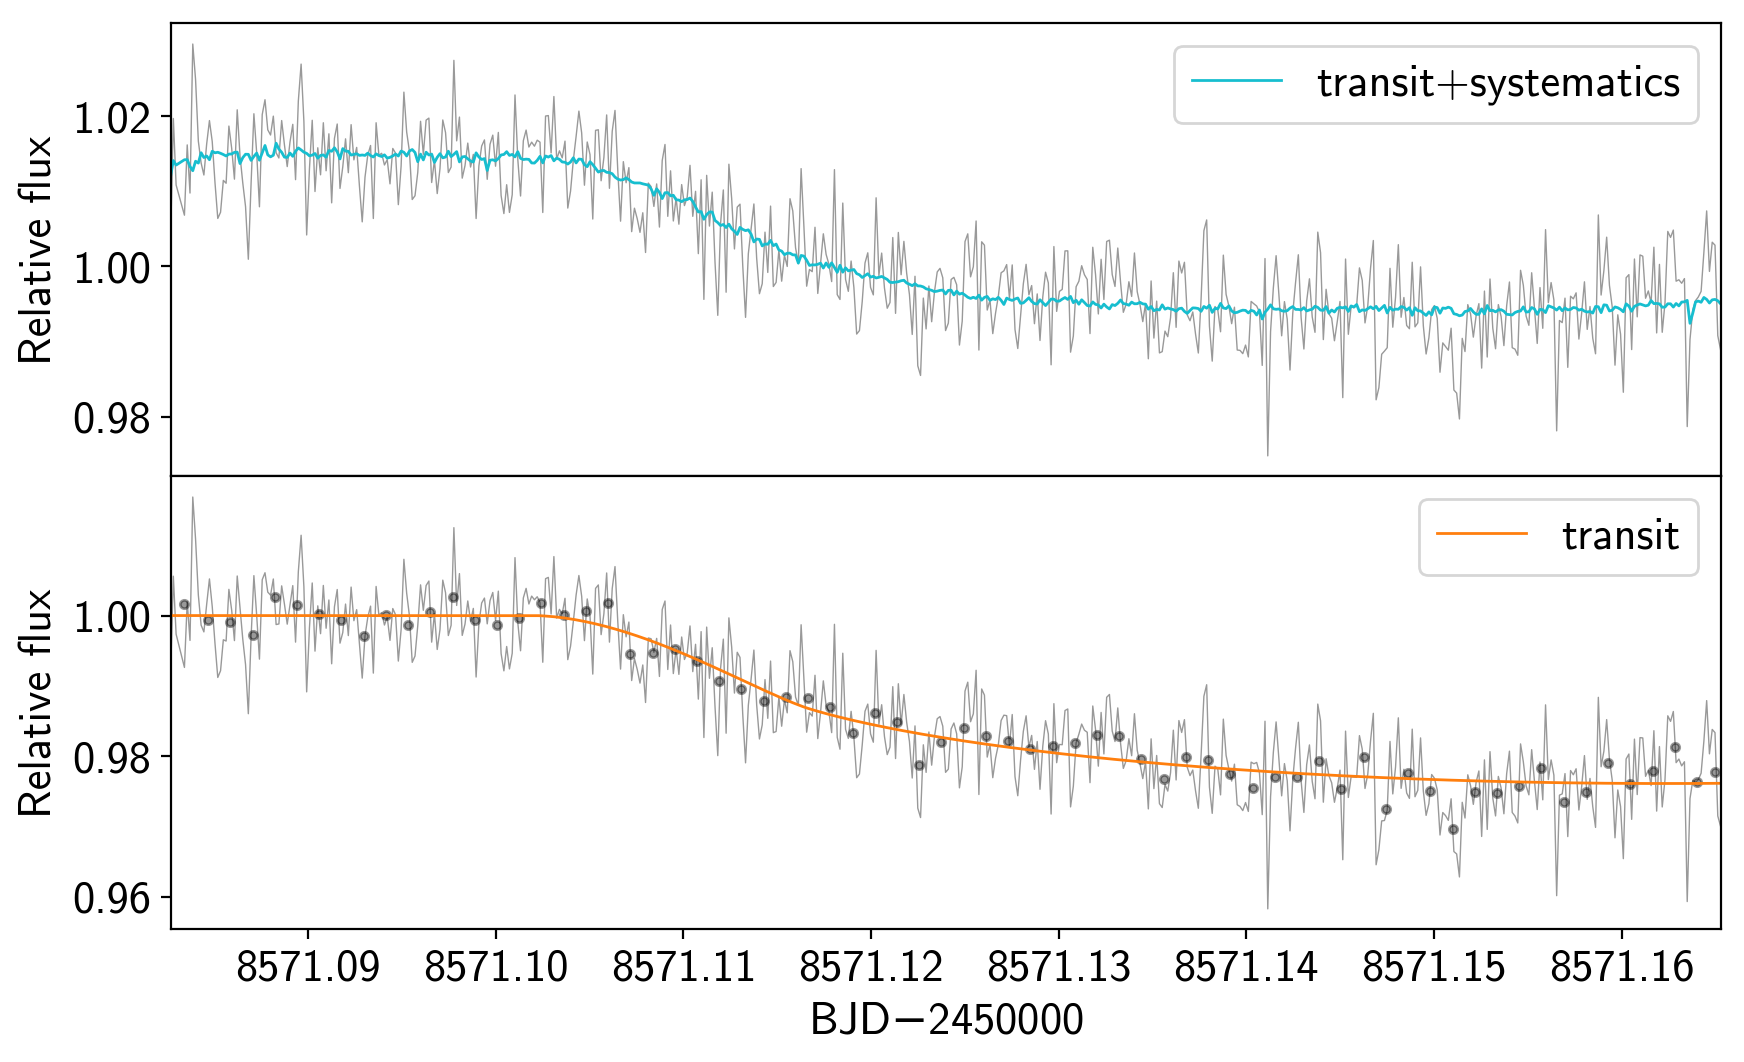

In [25]:
fit.plot_map()

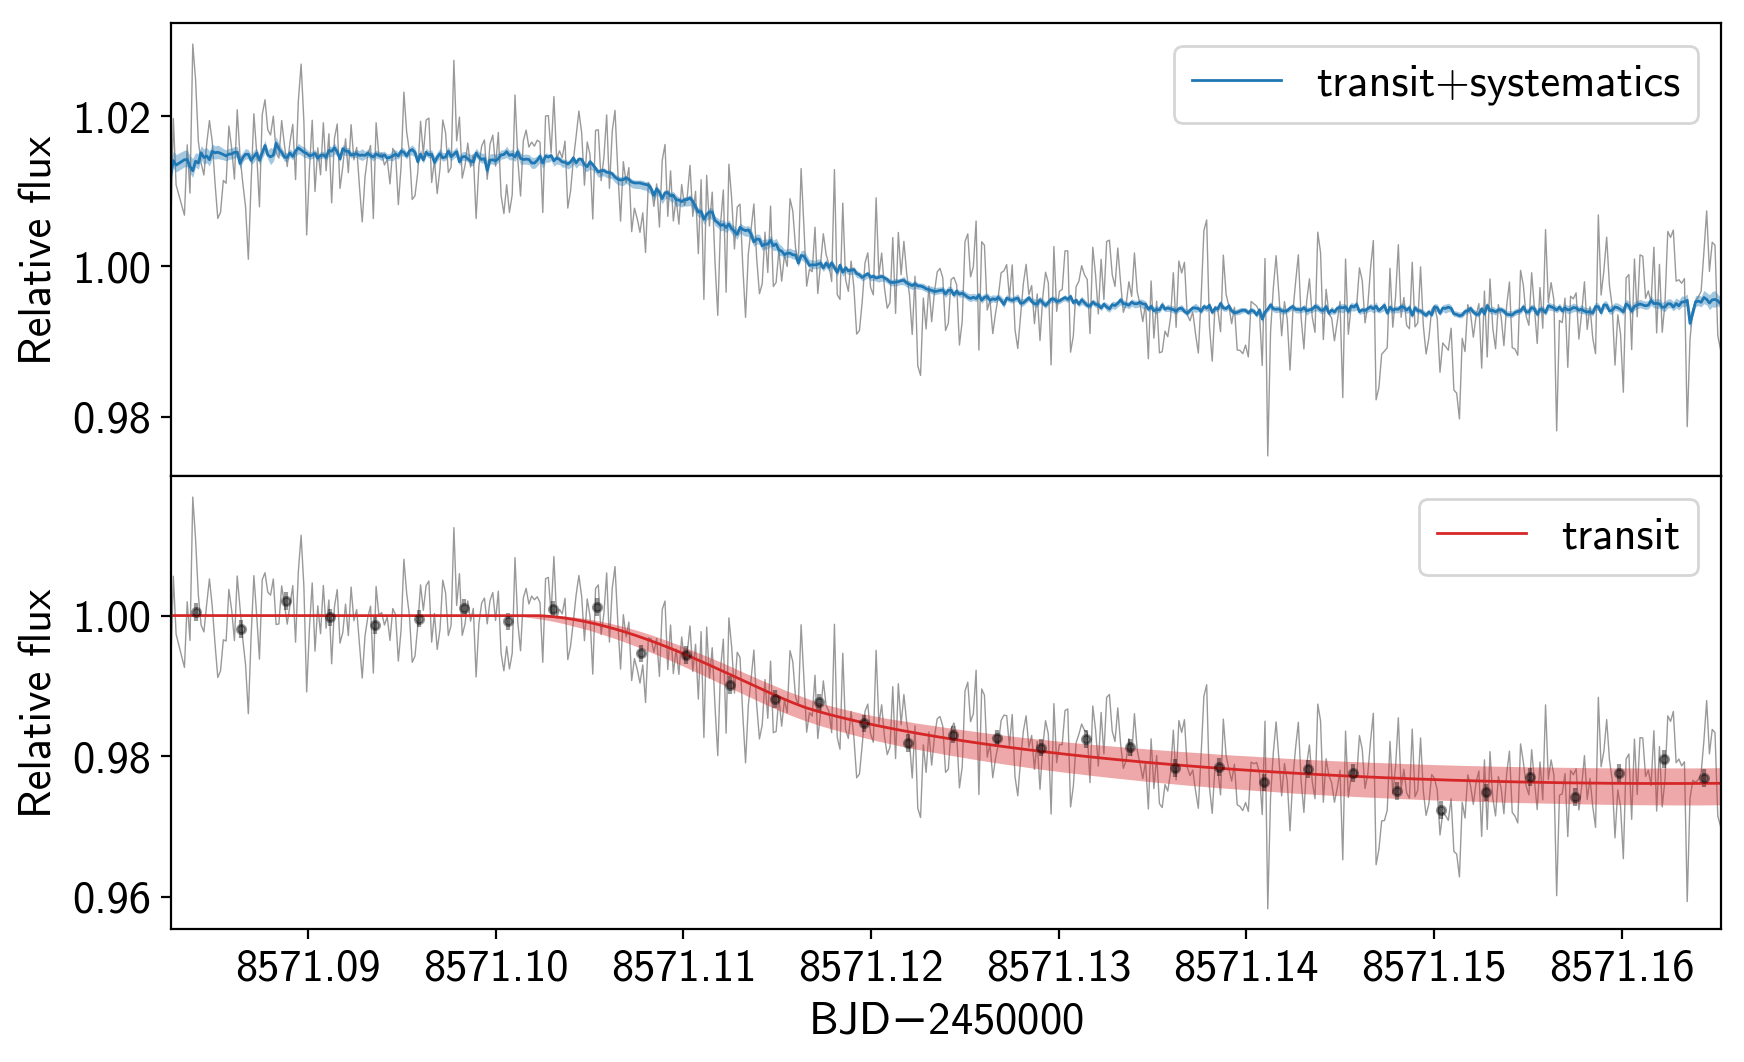

In [26]:
fig, axs = pl.subplots(2, 1, figsize=(10,6), sharex=True, sharey=False)
fit.plot_mcmc(binsize=16, c1='C0', c2='C3', sig=1, axs=axs)
# pl.setp(axs[1], ylim=(0.85,1.05))

In [27]:
fit.get_df(*star['rad']).describe()

t0            p            k            r            b  \
count  5.000000e+03  5000.000000  5000.000000  5000.000000  5000.000000   
mean   2.458571e+06     3.115237     0.134443     1.446572     0.216306   
std    2.109006e-03     0.000195     0.007620     0.228794     0.136500   
min    2.458571e+06     3.114583     0.103774     0.785006     0.000187   
25%    2.458571e+06     3.115103     0.129087     1.293571     0.104145   
50%    2.458571e+06     3.115234     0.133847     1.442370     0.200865   
75%    2.458571e+06     3.115368     0.139410     1.588462     0.310965   
max    2.458571e+06     3.115842     0.169579     2.513008     0.686385   

                q1           q2           ls           c0           c1  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.729559     0.492883    -5.282269    -0.006568    -0.014476   
std       0.145296     0.040519     0.028830     0.255641     0.103030   
min       0.284468     0.366591    -5.382447    -0.942905    -0.400651   
25%       0.626419     0.464508    -5.301282    -0.183963    -0.084582   
50%       0.731083     0.489497    -5.281490    -0.000313    -0.014780   
75%       0.843805     0.518755    -5.264089     0.169886     0.058019   
max       0.999954     0.724490    -5.175709     0.973691     0.368329   

          ...                c3           c4        rstar       pl_rad  \
count     ...       5000.000000  5000.000000  5000.000000  5000.000000   
mean      ...          0.360548     0.002618     0.699188    10.254729   
std       ...          0.147413     0.001899     0.099517     1.580154   
min       ...         -0.226225    -0.003658     0.273890     3.961171   
25%       ...          0.263239     0.001372     0.633170     9.218156   
50%       ...          0.365572     0.002558     0.698848    10.219783   
75%       ...          0.451759     0.003820     0.765549    11.307603   
max       ...          0.947461     0.010585     1.053105    16.796697   

                 a          inc          t14          t23        shape  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      9.028141    88.594709     0.121963     0.090896     0.745653   
std       0.481283     0.942103     0.005594     0.004594     0.028448   
min       7.384843    84.712207     0.103064     0.068048     0.555631   
25%       8.722517    87.990014     0.118105     0.088424     0.735331   
50%       9.044946    88.737691     0.121682     0.091155     0.752625   
75%       9.340592    89.349933     0.125708     0.093866     0.764251   
max      10.884080    89.998812     0.142140     0.105246     0.806084   

             max_k  
count  5000.000000  
mean      0.146018  
std       0.019322  
min       0.107368  
25%       0.133626  
50%       0.141145  
75%       0.152518  
max       0.285652  

[8 rows x 21 columns]